## Data prerequisites for k-means

In order to successfully apply k-means to clustering problems, there are three prerequisites the data must meet. If you apply k-means to data that does not meet these assumptions, you will get incorrect, unintuitive results. 

1. **Cluster number is k** K-means assumes that the correct cluster number is k. Since we provide the value of k to k-means, we need to determine the best value. However, most of the time determining k is not trivial and we need to run k-means with several k values and choose the one that makes most sense to us. In the next checkpoint, we'll discuss how to measure the performances of clustering algorithms. Using those techniques, we should choose the best k among the alternatives.
2. **Clusters are isotropic** K-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward. If this assumption fails, k-means would come up with unuseful clusters. However, in the later checkpoints of this module, we'll present other clustering methods that can handle non-isotropic clustering structures. 
3. **Similar variance** K-means also assumes all clusters have similar variance.

The plot below demonstrates how k-means can produce unintuitive clusters when its assumptions are not met. In particular, if we discover that our data violates the second and third assumptions, we need to resort to other clustering techniques that we'll cover in the later checkpoints in this module.

![k-means assumptions](assets/k_means_assumptions.png)

## Important points to consider

When applying k-means, there are some key points you'll need to consider:

* The initial selection of centroids is important. One popular way to begin is to randomly choose k of the samples. However, like other iterative algorithms with a random start, bad starting centroid values can cause k-means to arrive at lousy solutions. As a result, it's better to **try the algorithm a few times with different starting centroids**. The sklearn implementation has a nifty `kmeans++` option (which is also the default) for initializing centroids that are distant from each other, and this approach is less likely to result in a flawed solution. Moreover, by default, sklearn runs the algorithm 10 times (we can set it to a different value using `n_init` parameter) with different centroid seeds and selects the best output in terms of inertia. The gif below demonstrates how a suboptimal solution k-means arrives when initialized with bad starting centroids:
    ![bad k-means gif](assets/kmeans_bad.gif)

* The outcome of k-means can be sensitive to the scale of the data. So, **standardizing each variable is a common practice before applying k-means**.
* The results depend on the value of k. So, choosing the correct k is essential for the algorithm to find the correct clusters. But, how do we pick k? Unfortunately, there's not a clear-cut solution. What we do is to search for true k through trial and error. We pick some set of k and look at the clusters produced by the algorithm. Then we pick the value such that the algorithm seems to produce the most *reasonable* clusters. The *reasonable* clusters representing "real" divisions in the data will be stable across training set and test set. We'll cover this topic in more detail in the following checkpoint.

## Performance considerations

The average complexity of the k-means algorithm is $O(k n T)$, where n is the number of observations and T is the number of iterations. The worst case complexity is $O(n^{(k+2/p)})$ where n is the number of observations and p is the number of features. Hence, high-dimensional data tends to make k-means run more slowly because it is more computationally demanding to measure the distance between each data point and the mean in a higher-dimensional space. That being said, **in practice, k-means is one of the fastest clustering algorithms available**. 

A common practice when we have too many dimensions is to run a PCA on the data first to reduce dimensionality, and then search for clusters in the reduced data. When the number of observations is high (>=100k)and we have limited computational power or time, another option is to use `MiniBatchKMeans` in scikit-learn, which randomly samples subsets of the training data in each iteration. The loop steps are similar to those in the original:

1. Assign the samples to their nearest centroids.
2. Update the centroids based on the streaming average of all of the samples that have been assigned to the centroid so far.

The solution you get will be a little worse than regular k-means but the algorithm runs drastically faster.

## K-means in action

Scikit-learn has a module called `cluster` that includes several clustering algorithms including k-means.

### Synthetic data

K-means has an impressive ability to discover isotropic (a.k.a., circular) clusters. We can see this by running k-means on some randomly generated data. We'll randomly sample two normally distributed datasets with different means and then cluster them using k-means. Note that, although the means of the two variables are different, we make their variance the same. This is because k-means works best if the variances in the clusters are the same as we touched upon when we were discussing the assumptions of k-means.

We begin with importing the libraries we use:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

Then we define two variables called *cluster_1* and *cluster_2* by randomly sampling from normal distribution. We also standardize them using `StandardScaler` of `sklearn.preprocessing`:

In [2]:
cluster_1x = np.random.normal(10,5,500)
cluster_1y = np.random.normal(20,5,500)
cluster_1 = np.concatenate([cluster_1x.reshape(-1,1),cluster_1y.reshape(-1,1)], axis=1)

cluster_2x = np.random.normal(30,5,500)
cluster_2y = np.random.normal(20,5,500)
cluster_2 = np.concatenate([cluster_2x.reshape(-1,1),cluster_2y.reshape(-1,1)], axis=1)

all_data = np.concatenate([cluster_1,cluster_2],axis=0)

scaler = StandardScaler()
all_data = scaler.fit_transform(all_data)

To apply k-means, we use `KMeans` class from `sklearn.cluster` module. To measure the run time we use [`%timeit` magic command](https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit) of iPython:

57.9 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


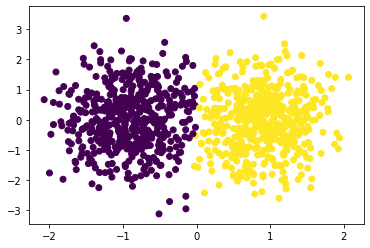

In [3]:
k_means = KMeans(n_clusters=2, random_state=123)
%timeit k_means.fit(all_data)
y_pred = k_means.predict(all_data)

# Plot the solution.
plt.scatter(all_data[:,0], all_data[:,1], c=y_pred)
plt.show()

Clusters seem to capture the correct grouping in the data and the algorithm took around 52 milliseconds to run. Now, let's try MiniBatchKMeans for comparison:

9.95 ms ± 520 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


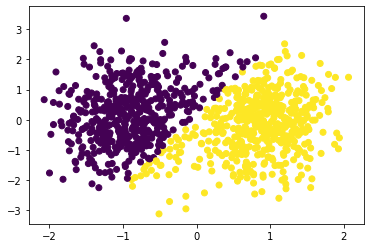

In [4]:
mini_batch_k_means = MiniBatchKMeans(n_clusters=2, random_state=123)
%timeit mini_batch_k_means.fit(all_data)
y_pred_mini = mini_batch_k_means.predict(all_data)

# Plot the solution.
plt.scatter(all_data[:,0], all_data[:,1], c=y_pred_mini)
plt.show()

MiniBatchKMeans also did a great job in less than half the time of the KMeans!

### Iris dataset

Now that we've seen k-means at work on randomly generated data, let's have a look at a real-world dataset. For this example, we'll use the famous [Iris data](https://archive.ics.uci.edu/ml/datasets/iris) from the UC Irvine Machine Learning Repository. This dataset a standard for exploring clustering and pattern recognition algorithms. It contains data on three types of iris plants, with 50 instances of each type. Among the three classes, one of them is linearly separable from the other two whereas the other two are not linearly separable from one another. 

The names of the iris plants are *Iris Setosa*, *Iris Versicolour*, and *Iris Virginica*. Each plant has four features:

1. Sepal length in cm.
2. Sepal width in cm.
3. Petal length in cm.
4. Petal width in cm.

In this example, our goal will be to create a k-means solution that correctly clusters the three types of iris plants.

Note that in this example we actually know the correct number of clusters in the data: three. But, we'll test whether k-means will assign observations as we expect it to do. Since k-means is an unsupervised learning algorithm, it will not use the information regarding the correct classes of the observations.

One important thing to keep in mind is that resulting clusters depend on the explanatory power of the variables that are fed into the clustering algorithms. In our example, the performance of k-means depends on the predictive power of the variables on identifying the plant type. So, if they are weak in this regard, then k-means won't be able to discern the correct classes.

To load the data, we'll use scikit-learn's `datasets` module. After we import the module (`from sklearn import datasets`), we load the dataset as follows: `iris = datasets.load_iris()`. 

Most of the clustering algorithms are sensitive to the scale of the data. So, before applying k-means, we also standardize our variables using the `StandardScaler` from `sklearn.preprocessing`:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import datasets

# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

We run k-means by setting `n_clusters=3`, since we have three classes of iris plant types in our data. The first assignment of this checkpoint asks you to play with this parameter and experiment with the results:

In [16]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=6, random_state=123)

# Fit model
%timeit kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

34 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's visualize the predictions and the true labels of the observations. To plot in two-dimensional space, we need to reduce our data dimensionality. For this purpose, we apply PCA and use the first two principal components.

In the plot below, the numbers show the cluster each observation has been assigned to by the algorithm. The colors denote the true classes.

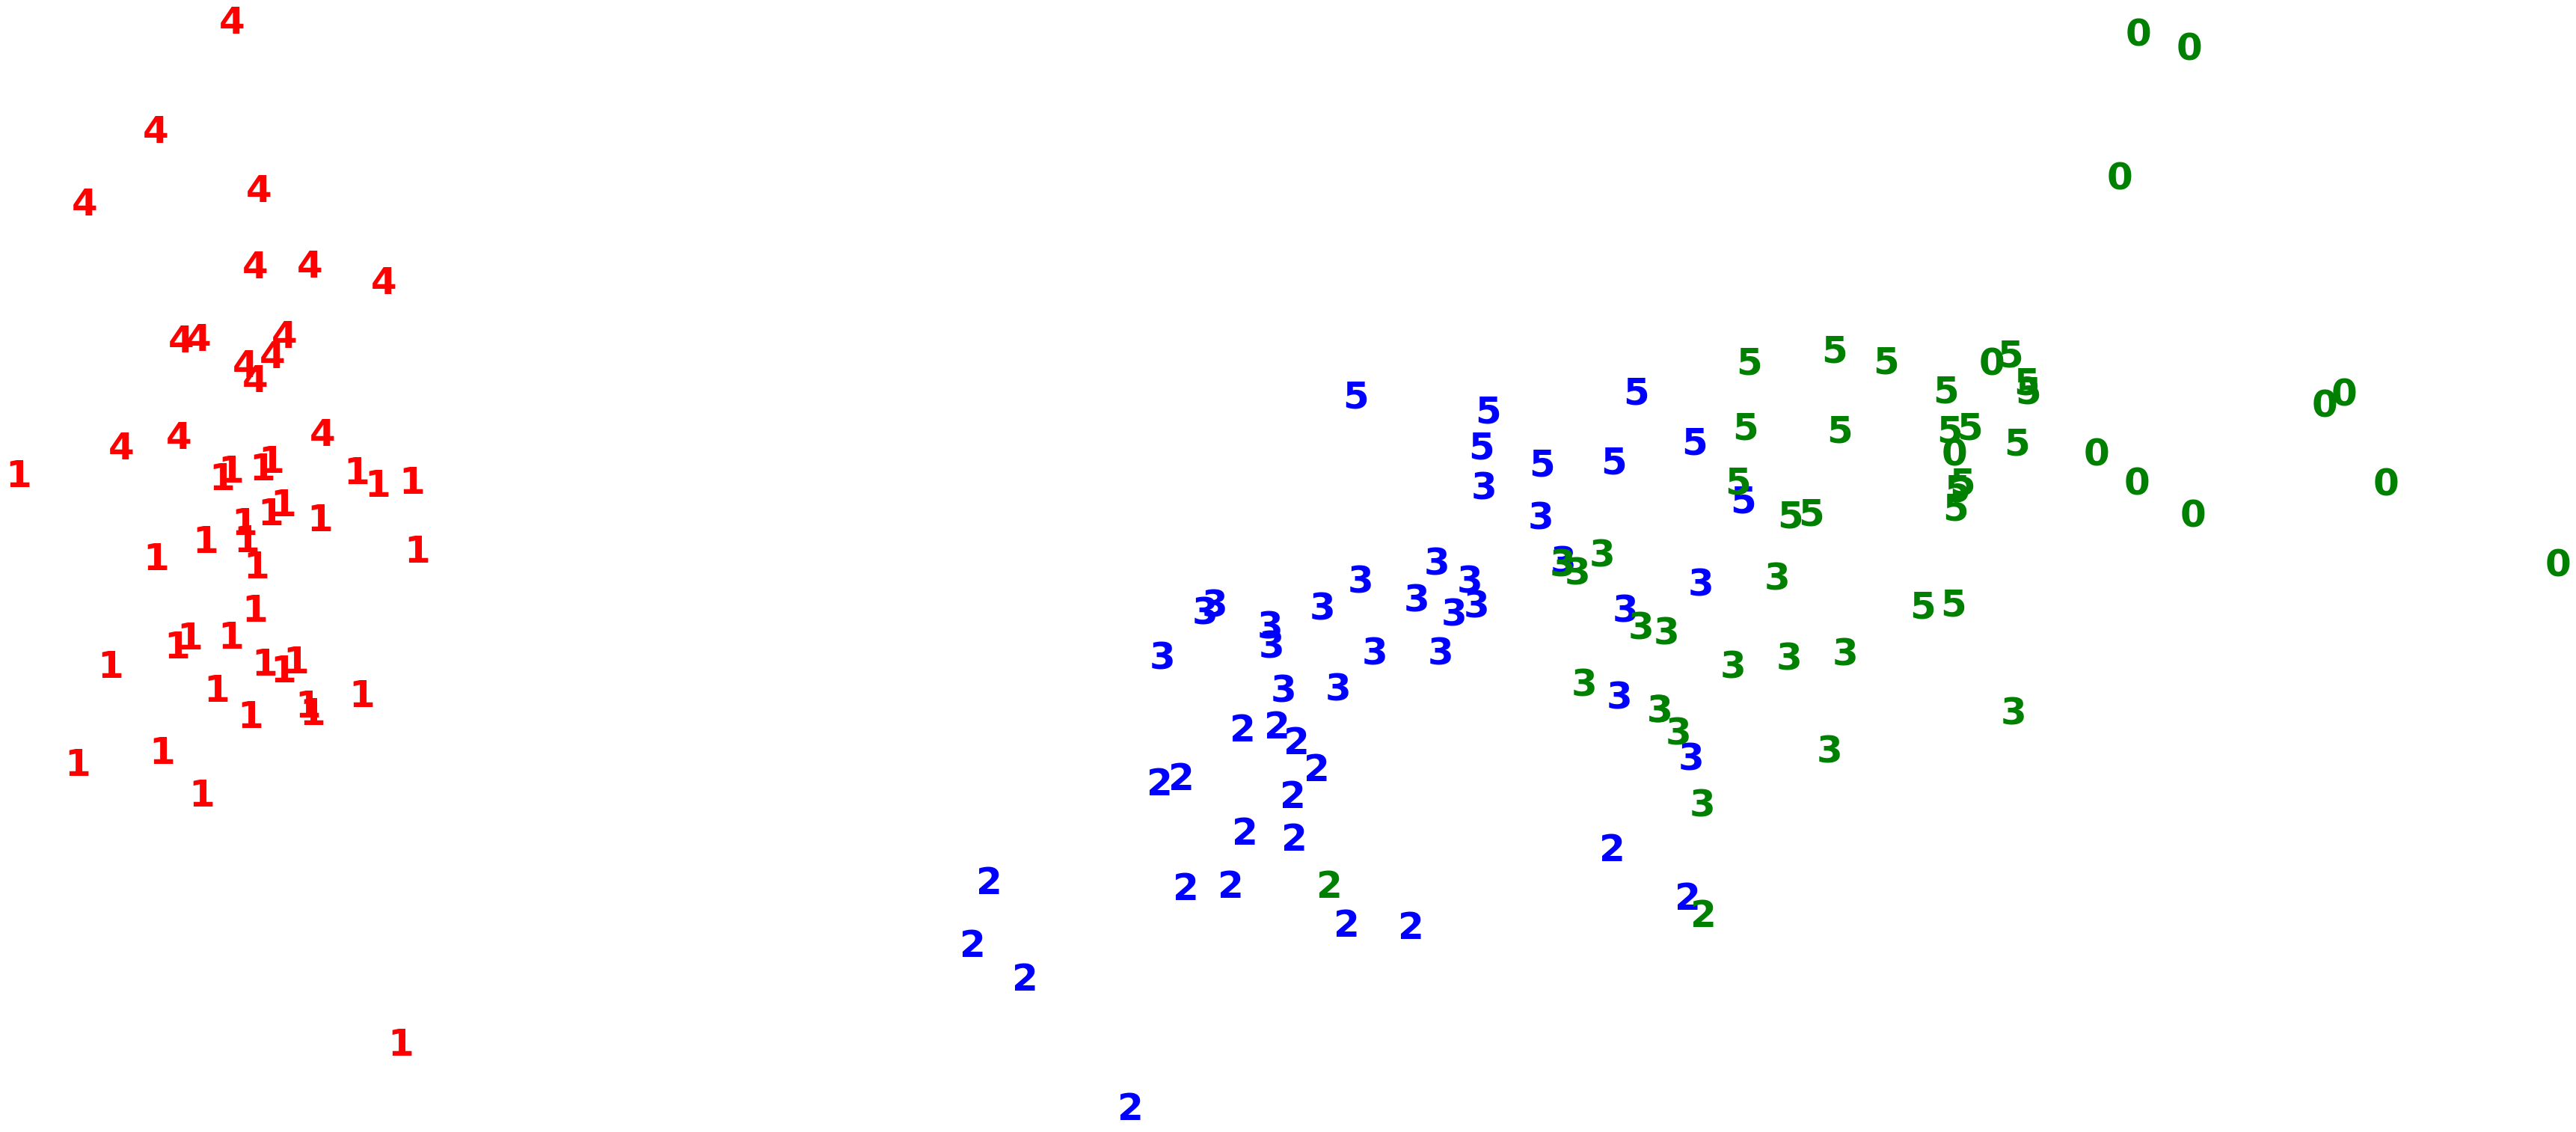

In [17]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

### Assignment 1: 
Your task is to apply k-means to the iris dataset and see what happens when you change the value of k. Which solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor. Keep in mind that it's possible you may find a solution with more than 3 clusters that nevertheless better tracks the real, trinary outcome – two of those clusters may map to a single flower type while the other two map to the other types for example.

- 5 clusters still appears to be optimum. 
- adding more clusters takes longer to run and the classes become less distinct.
- 2 clusters doesn't break apart 2 of the classes, which appear more similar than class "0". However, they do appear to show a difference in some degree...just not in the intuitive way we know it should.
- 4 clusters actually doesn't look too bad. The data on the left can be broken into 2 classes, much like the data cluster on the right side of the graph.

Not bad! K-means seems to successfully identify the linearly separable class from the other two. However, for the inseparable two classes, the algorithm produced some incorrectly assigned predictions. 

Next, let's try mini-batch k-means:

9.67 ms ± 607 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


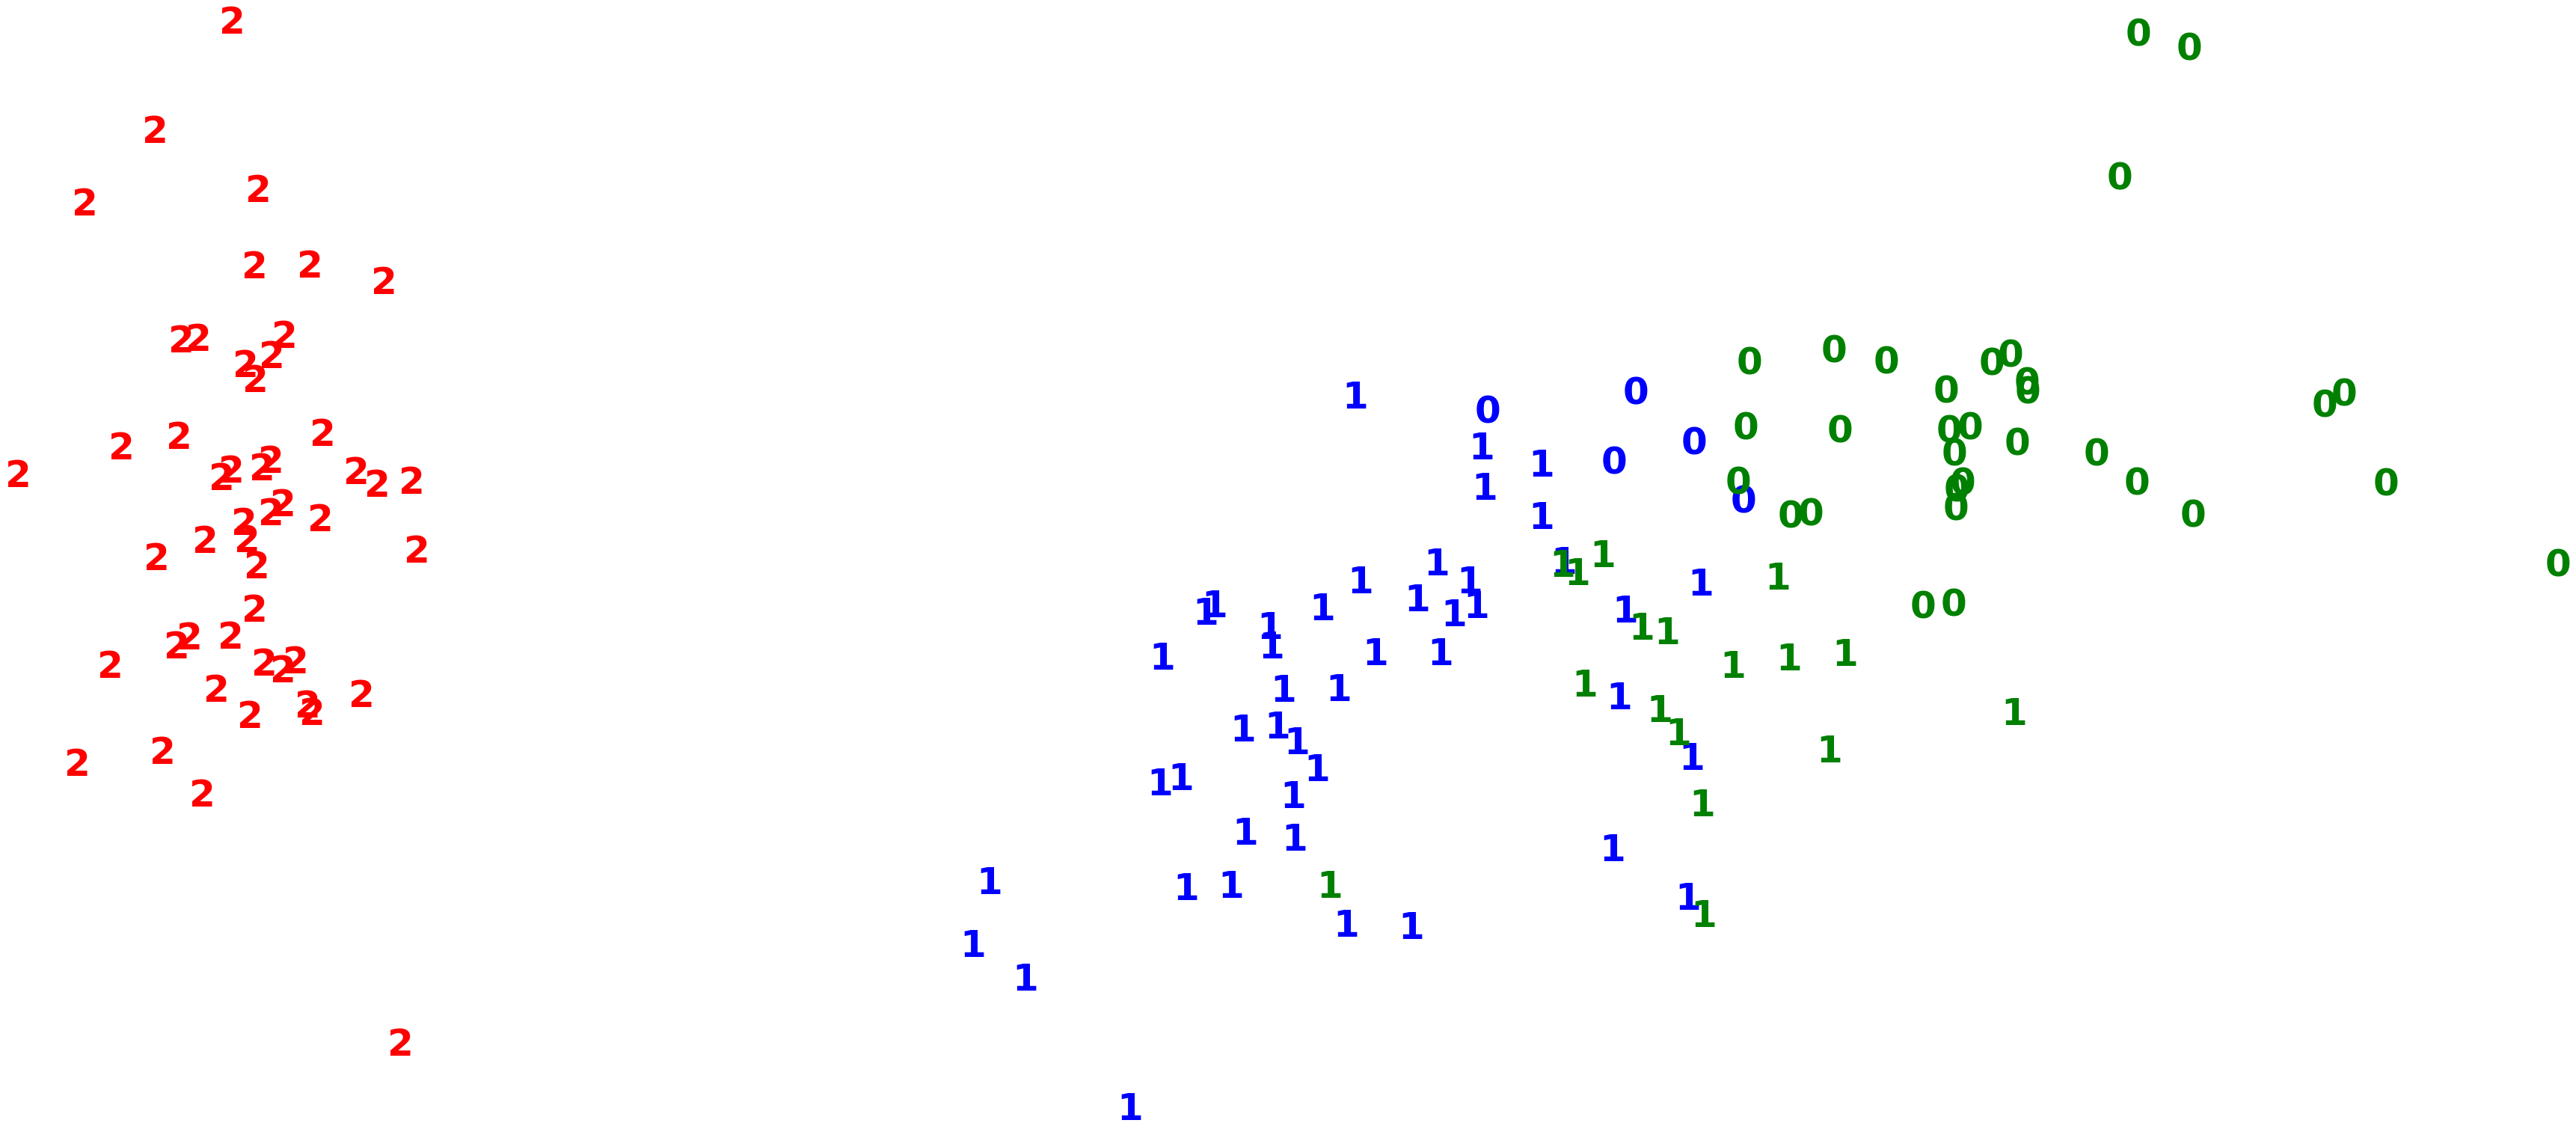

In [9]:
# Defining the mini-batch k-means
minikmeans_cluster = MiniBatchKMeans(
    init='random',
    n_clusters=3,
    batch_size=50)

# Fit model
%timeit minikmeans_cluster.fit(X_std)
minikmeans_cluster = minikmeans_cluster.predict(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(minikmeans_cluster[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Mini-batch k-means produced similar results but it was more than twice as fast.

Assignment
To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks below, and plan on discussing with your mentor. You can also take a look at these example solutions.
https://github.com/Thinkful-Ed/data-201-resources/blob/master/clustering_module_solutions/2.solution_kmeans.ipynb

Your task is to apply k-means to the iris dataset and see what happens when you change the value of k. Which solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor. Keep in mind that it's possible you may find a solution with more than 3 clusters that nevertheless better tracks the real, trinary outcome – two of those clusters may map to a single flower type while the other two map to the other types for example.

In this assignment, you'll be working with the heart disease dataset from the UC Irvine Machine Learning Repository.

Load the dataset from the Thinkful's database. Here's the credentials you can use to connect to the database:

In [3]:
# Import SQL Alchemy engine
from sqlalchemy import create_engine

In [4]:
# use credentials to start a connection
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

The dataset needs some preprocessing. So, apply the following code before working with the dataset:

In [5]:
# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

Here, X will be your features and in y we hold the labels. If y is equal to 1, then it indicates that the corresponding patient has heart disease and if y is equal to 0, then the patient doesn't have heart disease.

Create a k-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters. Note that in this case, we actually know the correct number of clusters in the data which is two. But, you'll test whether k-means will assign observations as we expect it to do. Since k-means is an unsupervised learning algorithm, it will be blind to whether or not patients have heart disease.

In [6]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

27.6 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


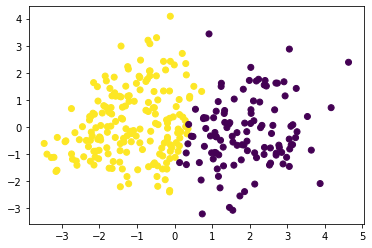

Comparing k-means clusters against the data:
col_0    0    1
row_0          
0      101   13
1       38  151


In [13]:
# Reduce it to two components for visualization
X_pca = PCA(n_components=2).fit_transform(X_std)

# Fit / calculate predicted values
k_means = KMeans(n_clusters=2, random_state=123)
%timeit k_means.fit(X_std)
y_pred = k_means.predict(X_std)

# Plot the solution.
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred)
plt.show()

# Check the solution against the data.
# You will learn about cross-tabs/contingency
# tables in the next checkpoint
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

It appears this model does a decent job at accurate predictions. 
 - 252 out of 304 cases.